
### 1. Dataset Description..
This assessment utilizes the **Movie Review Dataset** sourced from the HuggingFace Hub. Designed specifically for sentiment analysis, the data is partitioned into three distinct "mini-sets":

* **Training Set:** 25,000 entries (Supervised Learning).
* **Testing Set:** 25,000 entries (Supervised Learning).
* **Unsupervised Set:** 50,000 entries (Unsupervised Learning).

### 2. Data Structure & Features
Each entry in the dataset consists of two primary columns:

| Column Name | Data Type | Description |
| :--- | :--- | :--- |
| **`text`** | String | The actual content of the movie review. |
| **`label`** | Integer | A numerical representation of the sentiment. |

**Label Encoding:**
* **`0`**: Negative Sentiment (Train/Test sets)
* **`1`**: Positive Sentiment (Train/Test sets)
* **`-1`**: No Label (Unsupervised set only)

### 3. Project Goal & Methodology
The primary objective is to develop two **Natural Language Processing (NLP)** algorithms capable of predicting the sentiment of a given review.
The process will involve processing unstructured text to create meaningful numerical word representations.

We will train and compare two distinct classifiers:

 * Support Vector Machine (SVM): A classical machine learning approach.
 * Long Short-Term Memory (LSTM): A deep learning model.

The set can be found at: https://huggingface.co/datasets/stanfordnlp/imdb

### 1. LIBRARY IMPORTS

In [2]:
# This cell imports all the necessary libraries for the project.

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# NLTK for text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Scikit-learn for traditional ML
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc


# Gensim for Word2Vec
from gensim.models import Word2Vec

# TensorFlow/Keras for Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.src.callbacks import EarlyStopping
from keras.src.layers import Bidirectional, Dropout

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns
import numpy as np
# Download NLTK data and set configurations
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")

All libraries imported successfully.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\AlexLapos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\AlexLapos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AlexLapos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AlexLapos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. DATA LOADING

In [3]:

# Load the training, testing, and unsupervised datasets for the IMDB sentiment analysis task.
# The data is loaded directly from the Hugging Face datasets hub.
df_train = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/train-00000-of-00001.parquet")
df_test = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/test-00000-of-00001.parquet")
df_unsupervised = pd.read_parquet("hf://datasets/stanfordnlp/imdb/plain_text/unsupervised-00000-of-00001.parquet")

### 3. INITIAL DATA EXPLORATION


In [4]:
# These cells perform a quick check on the loaded data to understand its structure.
# Check the dimensions (rows, columns) of the training data.
df_train.shape


(25000, 2)

In [5]:
# Check the dimensions of the test data.
df_test.shape

(25000, 2)

In [6]:
# Display the column names of the training data.
df_train.columns

Index(['text', 'label'], dtype='object')

In [7]:
# Display the column names of the test data and the unique labels in the training data.
df_test.columns
df_train['label'].unique()

array([0, 1])

In [8]:
# Check the unique labels in the test data (0 for negative, 1 for positive).
df_test['label'].unique()

array([0, 1])

In [9]:
# Display a random sample of 10 movie reviews from the training set, this is done to be able to see what exactly pre processing we will be performing.
df_train['text'].sample(10)

5041     TV does influence society...just look at the s...
11582    What happened? Those were the first words to c...
22699    I have looked forward to seeing this since I f...
21040    It is difficult to evaluate this or any other ...
18285    There isn't a whole lot going on in this story...
1590     The first part, Che in Cuba, is about that por...
6617     I watched this movie after having so much of t...
15726    Besides the fact that it was one of the few mo...
16264    Saw it as critic at the 49. Internationales Fi...
7599     Many people see this as a classic, but I obvio...
Name: text, dtype: object

In [10]:
# Display a random sample of 10 movie reviews from the test set.We display the test df alos to make sure the format is the same
df_test['text'].sample(10)


23421    It ends with the declaration that "the film yo...
19985    It resembles so much to movies like PULP FICTI...
24587    Akin's prize-winning 2004 movie Head-On/Gegen ...
3030     Sometimes you just have to have patients when ...
15323    This is ten times better than "Who Wants To BE...
5784     This is possibly the single worst film i have ...
15007    I saw Peter Watkin's Culloden and The War Game...
24108    I would like to know if anyone know how I can ...
18049    This movie appears to have been overlooked by ...
1537     I could not watch more than 10 minutes of this...
Name: text, dtype: object

### Feature Engineering: Word2Vec Embeddings

We will employ **Word2Vec** to generate custom word embeddings. This approach allows the model to learn vector representations that capture the specific context of the dataset.

#### 1. Text Preprocessing Pipeline
Before training, we clean the dataset:

1.  **HTML Removal & Tokenization:** We strip HTML tags and split the text into individual tokens
2.  **Selective Stopword Removal:** We remove standard stopwords (e.g., 'the', 'and') but retain **negation words**.
    > **Why keep negations?**
    > * *Original:* "The movie was **not** good" (Negative)
    > * *Bad Removal:* "The movie was good" (Positive)
3.  **Normalization:** We lowercase , remove punctuation, and **lemmatize** the text to reduce words to their base roots.
4.  **Reconstruction:** The tokens are joined back together to create a standardized text corpus.

#### 2. Training the Embedding
We utilize the `gensim` library to train the Word2Vec model on the cleaned text using specific parameters:
* **Architecture:** Skip-gram (`sg=1`)
* **Dimensionality:** 300 dimensions

#### 3. Model Integration
The resulting custom vectors are applied differently for each classifier:

* **SVM (Support Vector Machine):** We calculate the **average** of the vectors for all words in a review.
* **LSTM (Deep Learning):** We use the vectors to populate an **Embedding Matrix**.

### 4. PREPROCESSING & UTILITY COMPONENTS


In [11]:
# This cell defines custom classes and functions for text preprocessing and vectorization.

class pre_process_text(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn transformer for preprocessing text data.
    It performs the following steps:
    - Removes HTML tags.
    - Tokenizes text into words.
    - Removes standard English stopwords but keeps sentiment-heavy words (e.g., 'not', 'very').
    - Lemmatizes and lowercases tokens.
    - Filters out non-alphabetic tokens.
    """
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        prep_sentences = []
        for text in X:
            # Remove HTML tags using a regular expression.
            text = re.sub(r'<.*?>', '', text)

            # Tokenize the text into a list of words.
            tokens = word_tokenize(text)

            # Define a set of stopwords to keep, as they are important for sentiment.
            words_to_keep = {
                    # Negations
                    'no', 'not', 'nor', 'never',
                    'ain', 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn',
                    'haven', 'isn', 'mightn', 'mustn', 'needn', 'shan', 'shouldn',
                    'wasn', 'weren', 'won', 'wouldn',
                    # Intensifiers & Comparisons
                    'very', 'too', 'more', 'most', 'few', 'such',
                    # Contrast
                    'but', 'against', 'same'
                }


            # Remove the important words from the set of stopwords to be filtered out.
            for word in words_to_keep:
                self.stop_words.discard(word)

            # Process each token: lemmatize, lowercase, and filter out non-alphabetic/stopword tokens.
            processed = [
                self.lemmatizer.lemmatize(token.lower())
                for token in tokens
                if token.isalpha() and token.lower() not in self.stop_words
            ]

            # Join the processed tokens back into a single string.
            prep_sentences.append(" ".join(processed))

        return prep_sentences

class Word2VecAverager(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn transformer that converts a list of documents (strings)
    into a matrix of averaged Word2Vec vectors. Each document is represented by
    the mean of the vectors of the words it contains.
    """
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model
        self.vector_size = w2v_model.wv.vector_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        avg_vectors = []
        # For each document, average the word vectors.
        for doc in X:
            doc_vectors = []
            for word in doc.split():
                if word in self.w2v_model.wv:
                    doc_vectors.append(self.w2v_model.wv[word])

            if not doc_vectors:
                # If a document has no words in the Word2Vec vocabulary, represent it with a zero vector.
                avg_vectors.append(np.zeros(self.vector_size))
            else:
                avg_vectors.append(np.mean(doc_vectors, axis=0))

        return np.array(avg_vectors)


def calculate_max_sentence_length(df, text_column='text', percentile=95, print_data=True):
    """
    Analyzes the text in a DataFrame to determine an optimal sentence length for padding.
    This helps in deciding the `maxlen` for LSTM sequences, balancing coverage and computational cost.
    this will be used in the LSTM agorithm
    """

    all_sentence_lengths = []

    for text in df[text_column]:
        for sentence in re.split(r'[.!?]+', text):
            word_count = len(sentence.split())
            if word_count > 0:  # Only count non-empty sentences
                all_sentence_lengths.append(word_count)

    # Calculate the length at the specified percentile to avoid outliers.
    max_length = int(np.percentile(all_sentence_lengths, percentile))

    if print_data:
        print(f"=== Sentence Length Statistics ===")
        print(f"Total sentences analyzed: {len(all_sentence_lengths)}")
        print(f"Maximum sentence length: {max(all_sentence_lengths)} words")
        print(f"{percentile}th percentile length: {max_length} words")
        print(f"Mean sentence length: {np.mean(all_sentence_lengths):.2f} words")
        print(f"Median sentence length: {np.median(all_sentence_lengths):.2f} words")
        print(f"\nUsing {max_length} as max_length will truncate ~{100-percentile}% of sentences")

    return max_length


### 5. DATA PREPARATION FOR MODELS


In [12]:
# Prepare the data splits for training and testing.
df_train = pd.DataFrame(df_train)
df_test = pd.DataFrame(df_test)

X_train = df_train['text']
y_train = df_train['label'].values
X_test = df_test['text']
y_test = df_test['label'].values

### Model 1: Support Vector Machine (SVM)

For the supervised learning phase, we rely on the **Support Vector Machine (SVM)**, a robust algorithm for binary classification tasks.

#### 1. Core Concept: The Hyperplane
The goal of the SVM is to determine the optimal **"hyperplane"**—a decision boundary that separates the dataset into positive and negative classes.
* **Support Vectors:** These are the data points located closest to the decision boundary.
* **The Margin:** The algorithm seeks the boundary with the largest possible margin (distance) between the hyperplane and these support vectors. Maximizing this gap ensures the model generalizes efficiently to new, unseen data.

#### 2. Implementation: Linear Kernel
While SVMs are famous for using "kernel tricks" to map complex data into higher dimensions for non-linear separation, this project utilizes a **Linear Kernel**.

> By strictly using a linear kernel, the model will attempt to divide the reviews along a straight line (or flat plane). This approach operates on the assumption that our averaged Word2Vec features are **linearly separable**—meaning the distinction between positive and negative vocabulary in the vector space is distinct enough to not require complex non-linear mapping.

### 6. SVM MODEL: SETUP AND TRAINING

In [13]:

# Instantiate the preprocessor.
pre_processor = pre_process_text()

# Preprocess the training text. This will be used to train the Word2Vec model.
processed_X_train = pre_processor.fit_transform(X_train)
processed_X_test = pre_processor.fit_transform(X_test)

# Tokenize the processed text for Word2Vec training.
tokenized_processed_train = [doc.split() for doc in processed_X_train]
tokenized_processed_test = [doc.split() for doc in processed_X_test]

# Define hyperparameters for the Word2Vec model.
embedding_dim = 300
min_word_count = 5
window_size =10
num_workers = 4

# Train the Word2Vec model on the tokenized training data.
word2vec_model = Word2Vec(
    sentences=tokenized_processed_train,
    vector_size=embedding_dim,
    window=window_size,
    min_count=min_word_count,
    workers=num_workers,
    sg=1,       # Use Skip-gram
    negative=5  # Use Negative Sampling
)

# Define the SVM classifier pipeline.
classsifier = Pipeline([
 ("preprocessor", pre_processor),
 ("vectorizer", Word2VecAverager(w2v_model=word2vec_model)),
 ("classifier", SVC(kernel="linear", probability=True, random_state=42)) # Enable probability for ROC curve
])



### 7. SVM MODEL: CROSS-VALIDATION


In [14]:
# Perform 5-fold stratified cross-validation to evaluate the SVM model's performance robustly.
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# Lists to store metrics for each fold.
svm_fold_accuracies = []
svm_fold_precisions = []
svm_fold_recalls = []
svm_fold_f1s = []
svm_fold_predictions = []

# Loop through each fold.
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
    print(f"\n--- Fold {fold + 1}/{kf.get_n_splits()} ---")
    # Data splitting
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    classsifier.fit(X_fold_train, y_fold_train)
    predictions = classsifier.predict(X_fold_val)
    acc = accuracy_score(y_fold_val, predictions)
    precision = precision_score(y_fold_val, predictions)
    recall = recall_score(y_fold_val, predictions)
    f1 = f1_score(y_fold_val, predictions)
    print(classification_report(y_fold_val, predictions))

    svm_fold_accuracies.append(acc)
    svm_fold_precisions.append(precision)
    svm_fold_recalls.append(recall)
    svm_fold_f1s.append(f1)

    # Print the average performance across all folds.
    print("\n--- Cross-Validation Results (5 Folds) ---")
    print(f"Average Accuracy:  {np.mean(svm_fold_accuracies):.4f} (+/- {np.std(svm_fold_accuracies):.4f})")
    print(f"Average Precision: {np.mean(svm_fold_precisions):.4f}")
    print(f"Average Recall:    {np.mean(svm_fold_recalls):.4f}")
    print(f"Average F1-Score:  {np.mean(svm_fold_f1s):.4f}")




--- Fold 1/5 ---
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2500
           1       0.86      0.86      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


--- Cross-Validation Results (5 Folds) ---
Average Accuracy:  0.8626 (+/- 0.0000)
Average Precision: 0.8627
Average Recall:    0.8624
Average F1-Score:  0.8626

--- Fold 2/5 ---
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2500
           1       0.86      0.87      0.86      2500

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000


--- Cross-Validation Results (5 Folds) ---
Average Accuracy:  0.8628 (+/- 0.0002)
Average Precision: 0.8605
Average Recall:    0.8660
Average F1-Sco

### Model 2: Long Short-Term Memory (LSTM)

The **Long Short-Term Memory (LSTM)** is a specialized type of Recurrent Neural Network (RNN) designed specifically for sequential data. Its ability to process sequences makes it ideal for reading and interpreting text.

#### 1. Overcoming the "Vanishing Gradient"
Standard RNNs struggle to retain context over long sequences due to the "vanishing gradient" problem. LSTMs solve this by using a sophisticated internal structure to maintain a **Cell State**—a mechanism often compared to an information conveyor belt.

This state is regulated by three distinct gates:

* **Forget Gate:** Determines which historical information is no longer relevant and should be discarded.
* **Input Gate:** Decides which new information is significant enough to be stored in the cell state.
* **Output Gate:** Controls what information flows out to the next step based on the current context.

#### 2. Our Architecture: Bidirectional & Stacked
For this assessment, i implemented a **Bidirectional, Stacked LSTM** to maximize performance:

* **Bidirectional:** The model reads the review in two directions simultaneously (start-to-end and end-to-start). This ensures the model captures the full context of a word based on what comes before *and* after it.
* **Stacked:** I utilize multiple LSTM layers stacked on top of one another, allowing the model to learn increasingly intricate, abstract patterns.
* **Regularization & Output:**
    * **Dropout Layers:** Applied to prevent overfitting by randomly ignoring neurons during training.
    * **Sigmoid Activation:** The final layer compresses the output into a probability between **0 and 1** (Negative vs. Positive).

### 8. LSTM MODEL: DATA PREPARATION


In [15]:
# Prepare the text data for input into the Keras LSTM model.
tokenized_processed_train = [review.split() for review in processed_X_train]
tokenized_processed_test = [review.split() for review in processed_X_test]

# Create and fit a Keras Tokenizer on the raw training text.
keras_tokenizer = Tokenizer()
keras_tokenizer.fit_on_texts(tokenized_processed_train) # Fit on the processed text
X_train_sequences = keras_tokenizer.texts_to_sequences(tokenized_processed_train)

# Determine the optimal padding length based on the 95th percentile of sentence lengths.
max_length = calculate_max_sentence_length(df_train)
print(max_length)

# Pad the integer sequences to ensure uniform length.
X_train_padded = pad_sequences(
    X_train_sequences,
    maxlen=max_length,
    padding='post'
)

# Determine the vocabulary size.
vocab_size = len(keras_tokenizer.word_index) + 1

# Create an embedding matrix to initialize the LSTM's Embedding layer.
# This leverages the pre-trained Word2Vec model.
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in keras_tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


=== Sentence Length Statistics ===
Total sentences analyzed: 334402
Maximum sentence length: 306 words
95th percentile length: 40 words
Mean sentence length: 17.66 words
Median sentence length: 16.00 words

Using 40 as max_length will truncate ~5% of sentences
40


### 9. LSTM MODEL: ARCHITECTURE AND CROSS-VALIDATION

In [16]:

def build_lstm_model():
    """Defines the architecture of the stacked Bidirectional LSTM model."""
    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,  # Use calculated max_length
        trainable=True  # Freeze the embeddings
    )) # Set to True to allow fine-tuning of embeddings.

    # Stacked Bidirectional LSTM layers
    model.add(Bidirectional(LSTM(
     units=100,
     recurrent_dropout=0.2,
     return_sequences=True  # Crucial for stacking: return the full sequence
    )))
    model.add(Dropout(0.3))


    model.add(Bidirectional(LSTM(
     units=64,  # The second layer can have fewer units
     recurrent_dropout=0.2
    )))

    model.add(Dropout(0.4))  # Slightly increased dropout for regularization

    # Final output layer for binary classification.
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define EarlyStopping to prevent overfitting by monitoring validation loss.
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

lstm_acc_scores = []
lstm_f1_scores = []
lstm_precision_scores = []
lstm_recall_scores = []

# Perform 5-fold cross-validation for the LSTM model.
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_padded, y_train)):
    print(f"\n--- Fold {fold + 1}/{kf.get_n_splits()} ---")

    # Data splitting
    X_fold_train = X_train_padded[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val = X_train_padded[val_idx]
    y_fold_val = y_train[val_idx]

    model = build_lstm_model()
    print(f"Training on {len(X_fold_train)} samples, validating on {len(X_fold_val)} samples.")
    model.fit(
        X_fold_train, y_fold_train,
        epochs=50,
        callbacks=[early_stopper],
        validation_data=(X_fold_val, y_fold_val),
        verbose=0
    )

    y_pred_probs = model.predict(X_fold_val)
    y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

    acc = accuracy_score(y_fold_val, y_pred_classes)
    precision = precision_score(y_fold_val, y_pred_classes, zero_division=0)
    recall = recall_score(y_fold_val, y_pred_classes, zero_division=0)
    f1 = f1_score(y_fold_val, y_pred_classes, zero_division=0)

    lstm_acc_scores.append(acc)
    lstm_f1_scores.append(f1)
    lstm_precision_scores.append(precision)
    lstm_recall_scores.append(recall)

    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")
    print(classification_report(y_fold_val, y_pred_classes, zero_division=0))





--- Fold 1/5 ---
Training on 20000 samples, validating on 5000 samples.
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Fold 1 Accuracy: 0.8386
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      2500
           1       0.83      0.85      0.84      2500

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000


--- Fold 2/5 ---
Training on 20000 samples, validating on 5000 samples.
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
Fold 2 Accuracy: 0.8342
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2500
           1       0.87      0.79      0.83      2500

    accuracy                           0.83      5000
   macro avg       0.84      0.83      0.83      5000
weighted avg       0.84      0.83      0.83      5000


--- Fold 3/5 ---
Training on 20000 samples, validating on 5000 samp

### Evaluation & Comparative Analysis

To ensure a rigorous comparison, we employ **5-Fold Stratified Cross-Validation**. This maintains the initial positive/negative class ratio across all folds, ensuring the SVM and LSTM models are evaluated on representative data.

#### Final Comparison Workflow
1.  **Models:** We predict with each of the models and measure their performance.
2.  **Test Set:** Final predictions are generated using the held-out test set.
3.  **Experimental Baseline:** We include a third "Experimental LSTM" trained on a combined vocabulary (Train + Test tokens) to evaluate the impact of a richer embedding matrix.

#### Visualizations & Metrics
We prioritize the **F1 Score** for ranking. To visualize performance, we generate:
* **ROC Curves:** To map sensitivity vs. specificity.
* **Confusion Matrices:** To identify specific misclassification patterns.
* **Bar Plots:** For a direct side-by-side performance comparison.

#### Analysis
The SVM model is performing better on a simple 0 and 1 clasification, but LSTM is not far behind , it might be because LSTM handles better more complex or abstract text  (the dataset that i use is very good for sentiment analysis).  The enhanced LSTM it seems is the weakest of all.  Since LSTM has more option to be changed there might just be a problem of optimization.

### 11. MODEL PERFORMANCE COMPARISON (LSTM ENHANCED)

In [17]:
# --- EXTRA CELL ---
# To Note:
# The enhanced LSTM model is just for experimantation only, it is done just to see how it performs

# 1. Combine training and unsupervised text
combined_text = pd.concat([df_train['text'], df_test['text']], ignore_index=True)

# 2. Preprocess the entire combined corpus
pre_processor = pre_process_text()
processed_combined_text = pre_processor.fit_transform(combined_text)
tokenized_corpus = [doc.split() for doc in processed_combined_text]
# 3. Train the ENHANCED Word2Vec model
embedding_dim = 300
word2vec_model_enhanced = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=embedding_dim,
    window=10,
    min_count=5,
    workers=4,
    sg=1,
    negative=5
)
print("Enhanced Word2Vec model training complete.")

# 4. Prepare Labeled Data for ENHANCED LSTM
print("\n--- 4. Preparing Labeled Data for Enhanced LSTM ---")

# Preprocess the labeled text
X_train_processed = pre_processor.transform(df_train['text'])

keras_tokenizer_enh = Tokenizer()
keras_tokenizer_enh.fit_on_texts(X_train_processed)

X_train_sequences_enh = keras_tokenizer_enh.texts_to_sequences(X_train_processed)
max_length = calculate_max_sentence_length(df_train)


X_train_padded_enh = pad_sequences(X_train_sequences_enh, maxlen=max_length, padding='post')

# Save as vocab_size_enh
vocab_size_enh = len(keras_tokenizer_enh.word_index) + 1

# Create ENHANCED Embedding Matrix
embedding_matrix_enhanced = np.zeros((vocab_size_enh, embedding_dim))
for word, i in keras_tokenizer_enh.word_index.items():
    if word in word2vec_model_enhanced.wv:
        embedding_matrix_enhanced[i] = word2vec_model_enhanced.wv[word]

# 5. Build and Train Models
print("\n--- 5. Building and Training Models ---")

# Define Enhanced Model using Enhanced Variables
def enhanced_lstm_model():
    model = Sequential([
        Embedding(
            input_dim=vocab_size_enh, # Use Enhanced Vocab Size
            output_dim=embedding_dim,
            weights=[embedding_matrix_enhanced], # Use Enhanced Matrix
            input_length=max_length,
            trainable=True
        ),
        Bidirectional(LSTM(units=100, recurrent_dropout=0.2, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(units=64, recurrent_dropout=0.2)),
        Dropout(0.4),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopper = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train Enhanced Model (using X_train_padded_enh)
print("Training Enhanced Model...")
en_lstm_model = enhanced_lstm_model()
en_lstm_model.fit(
    X_train_padded_enh, # Padded data
    y_train,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopper],
    verbose=1
)

# Train Standard Model (using original X_train_padded)
# Note: This uses the variables defined in Cell 14.
# Since we didn't overwrite them above, this is now safe.
print("Training Standard Model...")
lstm_model = build_lstm_model()
lstm_model.fit(
    X_train_padded,
    y_train,
    epochs=50,
    validation_split=0.1,
    callbacks=[early_stopper],
    verbose=1
)

[['rented', 'video', 'store', 'controversy', 'surrounded', 'first', 'released', 'also', 'heard', 'first', 'seized', 'custom', 'ever', 'tried', 'enter', 'country', 'therefore', 'fan', 'film', 'considered', 'controversial', 'really', 'see', 'plot', 'centered', 'around', 'young', 'swedish', 'drama', 'student', 'named', 'lena', 'want', 'learn', 'everything', 'life', 'particular', 'want', 'focus', 'attention', 'making', 'sort', 'documentary', 'average', 'swede', 'thought', 'certain', 'political', 'issue', 'such', 'vietnam', 'war', 'race', 'issue', 'united', 'state', 'asking', 'politician', 'ordinary', 'denizen', 'stockholm', 'opinion', 'politics', 'sex', 'drama', 'teacher', 'classmate', 'married', 'kill', 'year', 'ago', 'considered', 'pornographic', 'really', 'sex', 'nudity', 'scene', 'few', 'far', 'even', 'not', 'shot', 'like', 'cheaply', 'made', 'porno', 'countryman', 'mind', 'find', 'shocking', 'reality', 'sex', 'nudity', 'major', 'staple', 'swedish', 'cinema', 'even', 'ingmar', 'bergman

Generating SVM Predictions...
Generating Standard LSTM Predictions...
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step
Generating Enhanced LSTM Predictions...
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 22ms/step


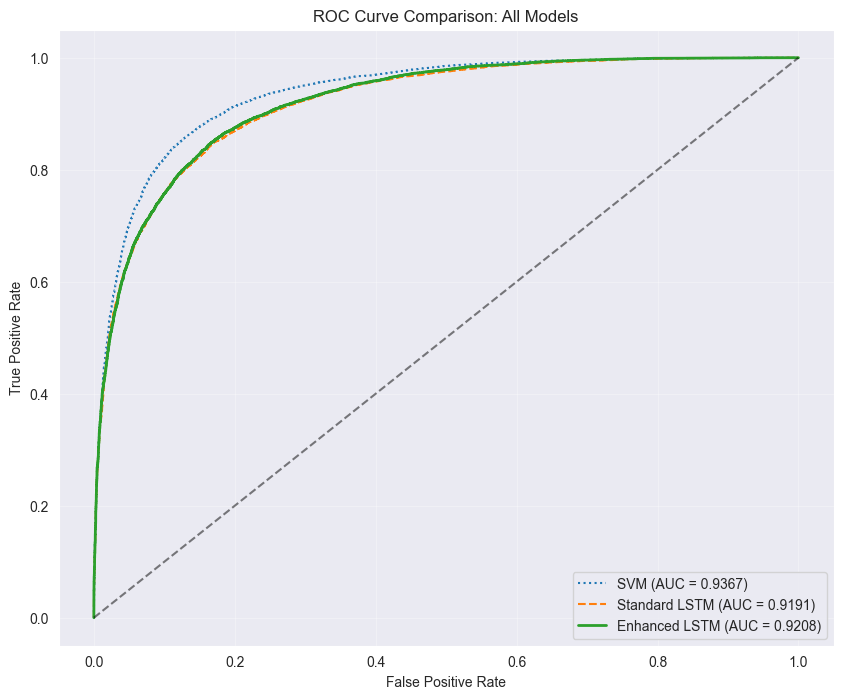

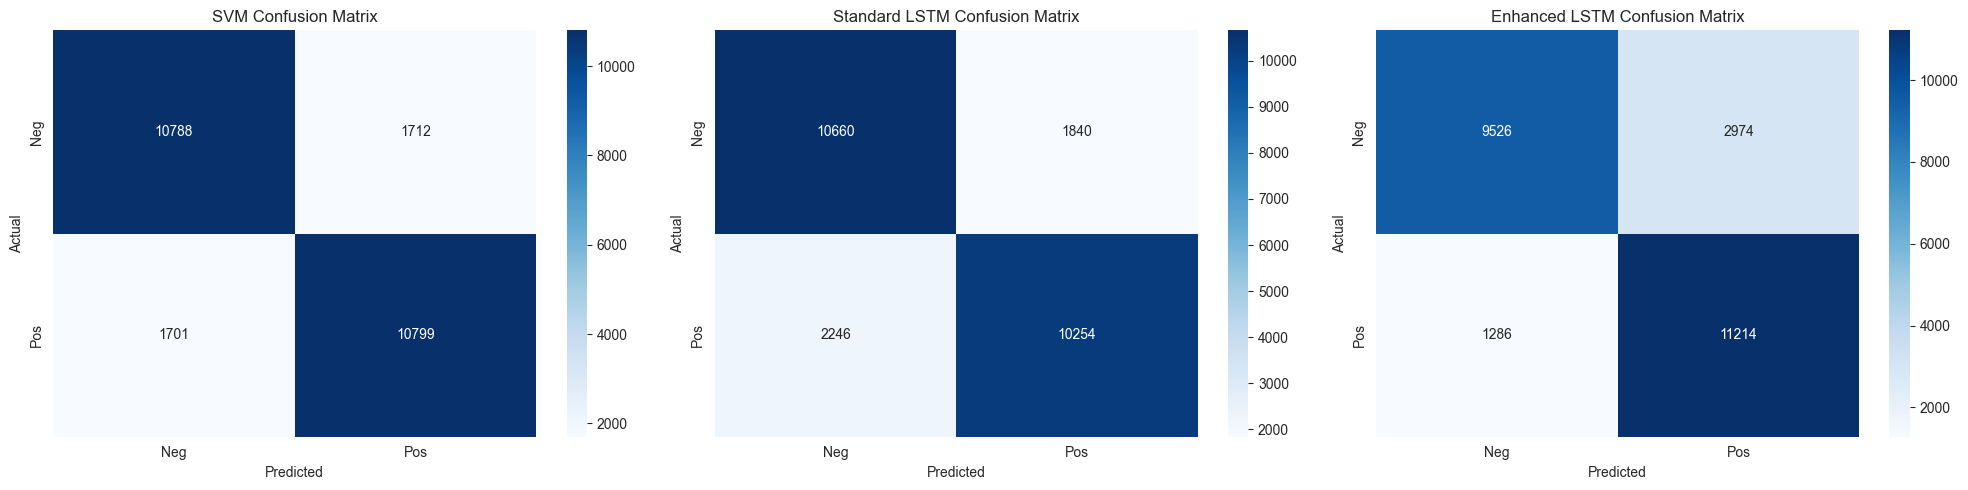

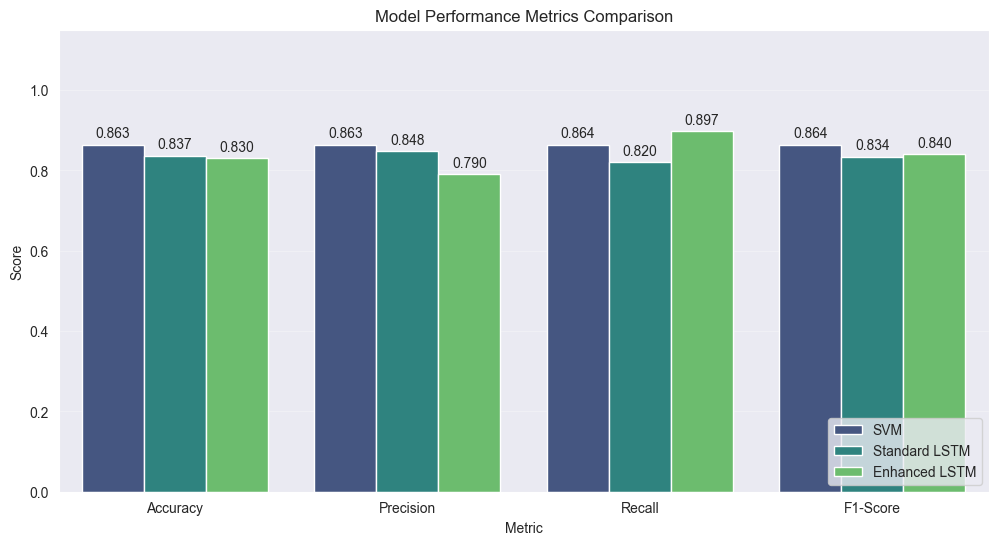


=== COMPARATIVE METRICS ===

--- SVM ---
              precision    recall  f1-score   support

           0     0.8638    0.8630    0.8634     12500
           1     0.8632    0.8639    0.8635     12500

    accuracy                         0.8635     25000
   macro avg     0.8635    0.8635    0.8635     25000
weighted avg     0.8635    0.8635    0.8635     25000


--- Standard LSTM ---
              precision    recall  f1-score   support

           0     0.8260    0.8528    0.8392     12500
           1     0.8479    0.8203    0.8339     12500

    accuracy                         0.8366     25000
   macro avg     0.8369    0.8366    0.8365     25000
weighted avg     0.8369    0.8366    0.8365     25000


--- Enhanced LSTM ---
              precision    recall  f1-score   support

           0     0.8811    0.7621    0.8173     12500
           1     0.7904    0.8971    0.8404     12500

    accuracy                         0.8296     25000
   macro avg     0.8357    0.8296    0.8

In [18]:

# --- 1. Gather Predictions on TEST DATA ---

# A. SVM Predictions
# Note: SVM expects raw text passed through the pipeline
print("Generating SVM Predictions...")
y_pred_svm = classsifier.predict(X_test)
y_prob_svm = classsifier.predict_proba(X_test)[:, 1] # Get probability of a positive class

# B. Standard LSTM Predictions
# Note: Requires manual preprocessing/tokenization sequence
print("Generating Standard LSTM Predictions...")
# Note: is woth noteing that we trained this tokenizer on Lists of Tokens, you must feed it Lists of Tokens (tokenized_processed_test) when making predictions
# in case the discrepancy is noteable
# Ensure we use the tokenizer fitted for the Standard LSTM
X_test_seq_std = keras_tokenizer.texts_to_sequences(tokenized_processed_test)
X_test_pad_std = pad_sequences(X_test_seq_std, maxlen=max_length, padding='post')

y_prob_lstm_std = lstm_model.predict(X_test_pad_std).flatten()
y_pred_lstm_std = (y_prob_lstm_std > 0.5).astype(int)

# C. Enhanced LSTM Predictions
# Note: Uses the same tokenizer/padding variables as defined in Cell 17
# Note: We feed it Strings (X_test_processed) when making predictions, this is done to se
# if we notice better results
print("Generating Enhanced LSTM Predictions...")

X_test_processed = pre_processor.transform(X_test)
X_test_seq_enh = keras_tokenizer_enh.texts_to_sequences(X_test_processed)
X_test_padded = pad_sequences(X_test_seq_enh, maxlen=max_length, padding='post')
# -------------------------------
y_prob_lstm_enh = en_lstm_model.predict(X_test_padded).flatten()
y_pred_lstm_enh = (y_prob_lstm_enh > 0.5).astype(int)

# --- 2. Plot ROC Curves (Comparison) ---

plt.figure(figsize=(10, 8))

# SVM ROC
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.4f})', linestyle=':')

# Standard LSTM ROC
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_prob_lstm_std)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.plot(fpr_lstm, tpr_lstm, label=f'Standard LSTM (AUC = {roc_auc_lstm:.4f})', linestyle='--')

# Enhanced LSTM ROC
fpr_enh, tpr_enh, _ = roc_curve(y_test, y_prob_lstm_enh)
roc_auc_enh = auc(fpr_enh, tpr_enh)
plt.plot(fpr_enh, tpr_enh, label=f'Enhanced LSTM (AUC = {roc_auc_enh:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) # Random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# --- 3. Plot Confusion Matrices (Side-by-Side) ---

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

models = [
    ('SVM', y_pred_svm),
    ('Standard LSTM', y_pred_lstm_std),
    ('Enhanced LSTM', y_pred_lstm_enh)
]

for i, (name, preds) in enumerate(models):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


# --- 4. Metric Comparison Bar Chart (NEW) ---

# Calculate metrics for all models
metrics_data = []
for name, preds in models:
    metrics_data.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, zero_division=0),
        'Recall': recall_score(y_test, preds, zero_division=0),
        'F1-Score': f1_score(y_test, preds, zero_division=0)
    })

# Convert to DataFrame and melt for plotting
df_metrics = pd.DataFrame(metrics_data)
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3, fontsize=10)

plt.ylim(0, 1.15)  # Add some headroom for labels
plt.title('Model Performance Metrics Comparison')
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()


# --- 5. Final Text Report ---
print("\n=== COMPARATIVE METRICS ===")
for name, preds in models:
    print(f"\n--- {name} ---")
    print(classification_report(y_test, preds, digits=4, zero_division=0))
